# Прогнозирование оттока клиентов Банка

**Цели исследования:**

Построить модели прогнозирования, способные предсказывать, уйдёт клиент из банка в ближайшее время или нет.

<b>Ход исследования:</b>

На предоставленных исторических данных о поведении клиентов и расторжении договоров с банком будут натренированны модели классификации, предсказывающие уход клиентов.</br>

Иследование будет включать в себя следующие шаги:
   - Загрузка и подготовка данных
   - Исследование баланса классов
       - Обучение модели без учёта дисбаланса
       - Повышение качества модели, учитывая дисбаланс классов
       - Выводы
   - Обучение разных моделей и выявление лучшей
       - Построение модели с наибольшим значением f1-меры
       - Выводы
   - Проведение финального тестирования
       - Проверка f1-меры на тестовой выборке
       - Измерение AUC-ROC меры и сравнивайте её значение с f1-мерой
   - Общий вывод

<b>Результаты исследования:</b><br>

В ходе исследования данных и построения моделей прогнозирования были получены следующие результаты:

- Показано, что балансировка несбалансированных данных как правило улучшает оценки модели. Обнаружено, что разные методы балансировки по-разному влияют на результат в зависимости от типа используемой ML-модели. В ходе исследования была выявлена более высокая чувствительность метрики f1 (относительно ROC-AUC) к дисбалансу классов целевой переменной.
- Цели работы достигнуты: построена ML-модель, способная предсказывать отток клиентов с большим показателем f1-меры, чем установленны заказчиком минимум. 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import sys

from tqdm import tqdm

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, SplineTransformer
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, ParameterSampler

from xgboost import XGBClassifier

## Загрузка и подготовка данных

In [4]:
churn = pd.read_csv('/home/panther/Documents/Deep Learning/datasets/Churn.csv')
churn.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [5]:
# удаляю RowNumber
churn = churn.drop('RowNumber', axis=1)

In [6]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           9091 non-null   float64
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(3), int64(7), object(3)
memory usage: 1015.8+ KB


Всем данным присвоен корректный тип, в столбце `Tenure` есть пропуски. Заполняются ниже.

Проверка колонок признаков на аномальные значения:

In [7]:
churn.drop('CustomerId', axis=1).apply('describe')

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [8]:
churn[['Geography', 'Gender']].apply('describe')

,Geography,Gender
count,10000,10000
unique,3,2
top,France,Male
freq,5014,5457


Аномальных значений не выявлено.

Маски для категориальных и числовых признаков, а также целевой признак и русские имена:

In [9]:
num_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary', 'NumOfProducts']
cat_cols = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']
tar_col = 'Exited'

ru_name = {'RowNumber': 'Индекс строки',
           'CustomerId': 'Идентификатор клиента',
           'Surname': 'Фамилия',
           'CreditScore': 'Кредитный рейтинг',
           'Geography': 'Страна проживания',
           'Gender': 'Пол',
           'Age': 'Возраст',
           'Tenure': 'Клиентский стаж',
           'Balance': 'Баланс счета',
           'NumOfProducts': 'Количество продуктов',
           'HasCrCard': 'Наличие кредитной карты',
           'IsActiveMember': 'Активность клиента',
           'EstimatedSalary': 'Предполагаемая зарплата',
           'Exited': 'Факт ухода'
          }

In [10]:
# проверка на явные дубликаты строк
churn.duplicated().sum()

0

Есть пропуски в колонке "клиентского стажа", заполняю их ниже (после графического анализа):

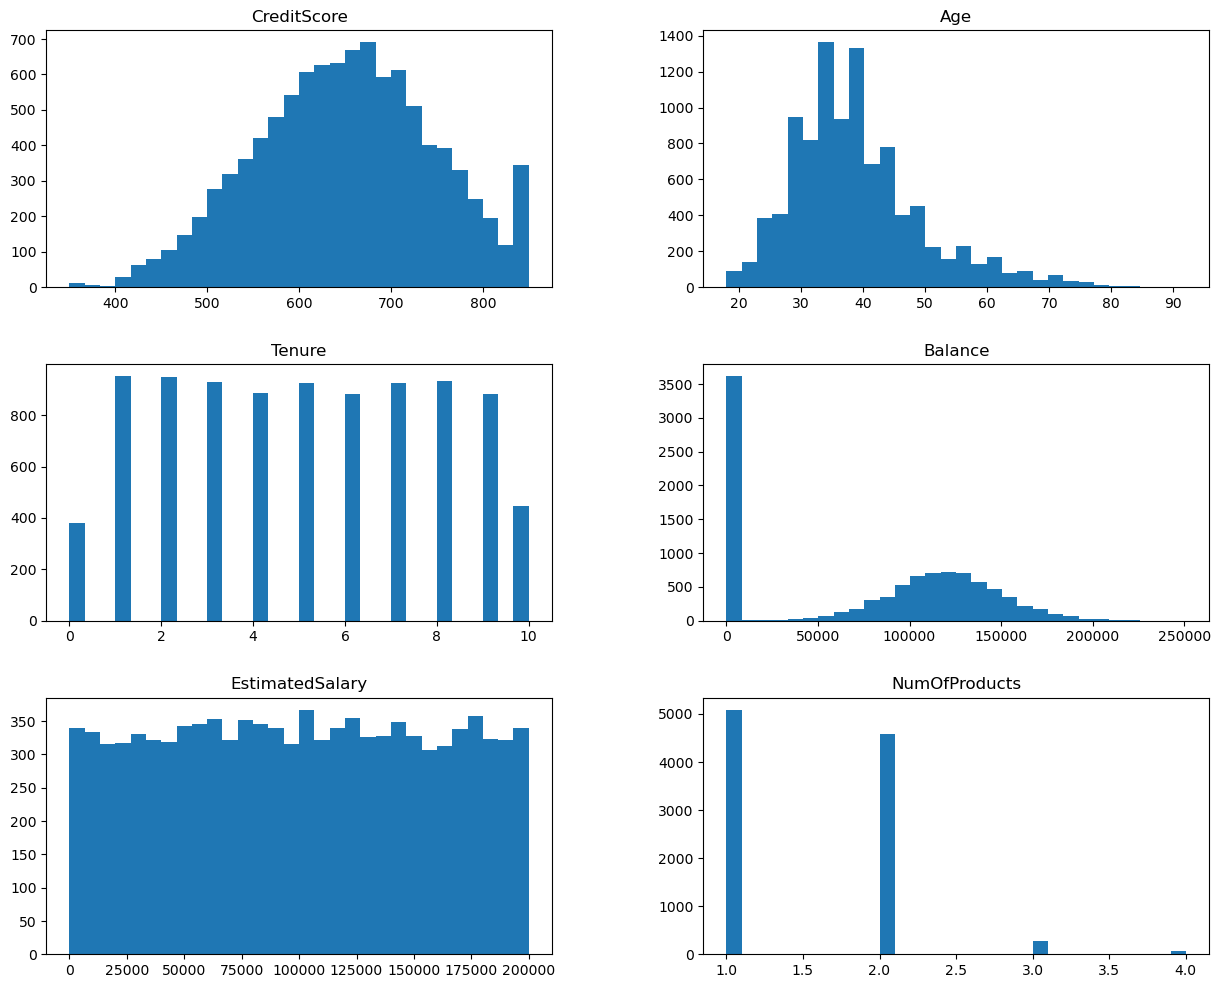

In [11]:
churn[num_cols].hist(bins=30, figsize=(15, 12), grid=False);

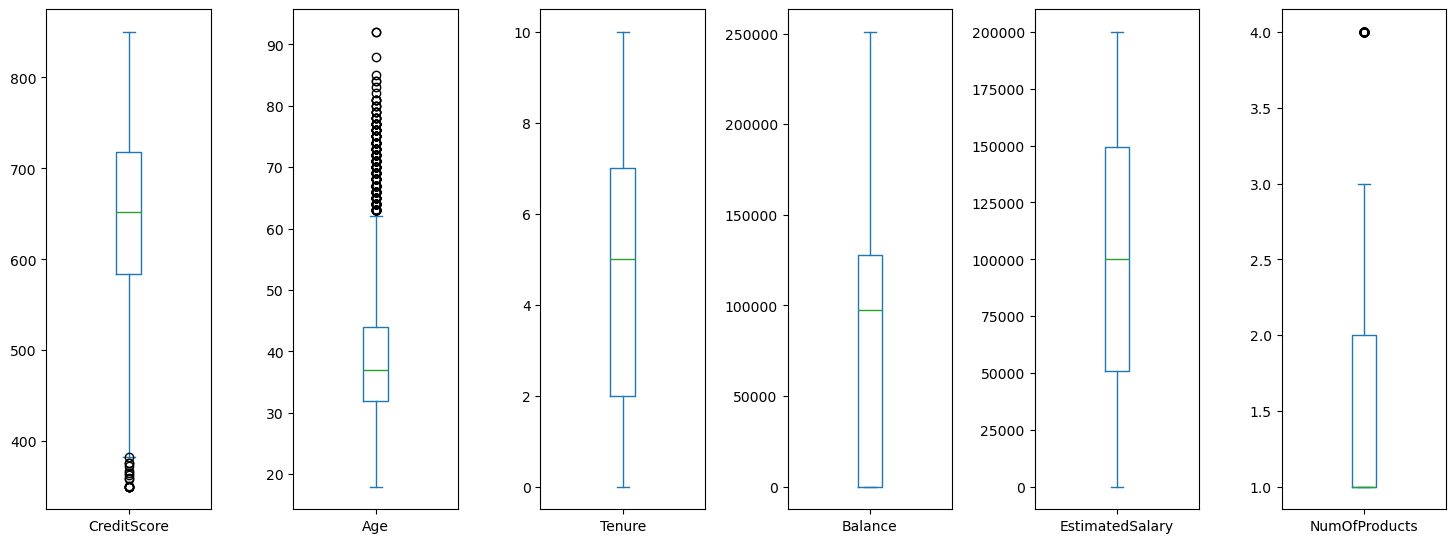

In [12]:
churn[num_cols].plot.box(subplots=True, figsize=(14, 5));
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.5, hspace=0.1);

В колонке "клиентского стажа (Tenure)" существенное количество пропусков, значения целочисленные и с почти равномерным разбросом (от 0 до 10), поэтому имеет смысл использовать медианное значение выборки для заполнения пропусков:

In [13]:
churn['Tenure'] = churn['Tenure'].fillna(churn['Tenure'].median())

Распределение категориальных признаков:

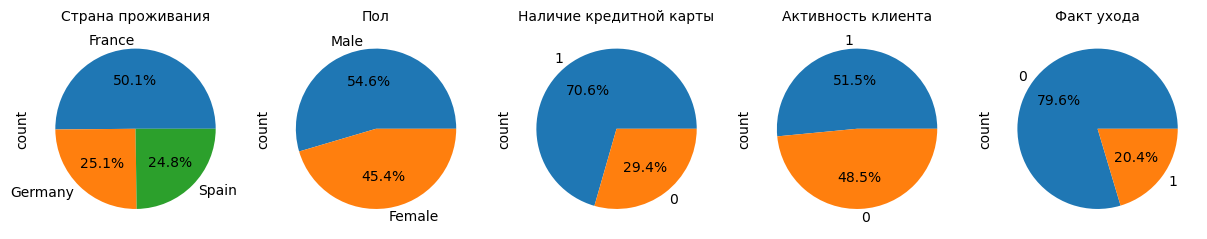

In [14]:
fig, axes = plt.subplots(ncols=5, nrows=1, figsize=(15, 5))
for i, col in enumerate(cat_cols+['Exited']):
    churn[col].value_counts().plot.pie(ax=axes[i], autopct='%1.1f%%')
    axes[i].set_title(ru_name[col], fontsize=10)

В целевой переменной заметен дисбаланс классов примерно 1 к 4. По заданию модели будут обучены как и с исправлением дисбаланса, так и без.

Проверка скоррелированности числовых признаков:

In [15]:
churn[num_cols].corr()

,CreditScore,Age,Tenure,Balance,EstimatedSalary,NumOfProducts
CreditScore,1.000000,-0.003965,-0.000060,0.006268,-0.001384,0.012238
Age,-0.003965,1.000000,-0.012606,0.028308,-0.007201,-0.030680
Tenure,-0.000060,-0.012606,1.000000,-0.007535,0.010049,0.011409
Balance,0.006268,0.028308,-0.007535,1.000000,0.012797,-0.304180
EstimatedSalary,-0.001384,-0.007201,0.010049,0.012797,1.000000,0.014204
NumOfProducts,0.012238,-0.030680,0.011409,-0.304180,0.014204,1.000000


Заметной корреляции между признаками не выявлено.

Выделение целевой переменной и отбрасывание лишних признаков:

In [16]:
# признаки фамилии и уникального идентификационного номера лишние для дальнейшего анализа

features = churn.drop(['Exited', 'CustomerId', 'Surname'], axis=1)
target = churn[tar_col]

Объявление необходимых в дальнейшем функций:

In [17]:
# функция для устранения дисбаланса целевой переменной
def upsample(X, y):
    upsamp_mult = round(y.value_counts().max()/y.value_counts().min())
    X_zeros = X[y == 0]
    X_ones = X[y == 1]
    y_zeros = y[y == 0]
    y_ones = y[y == 1]
    features = pd.concat([X_zeros] + [X_ones] * upsamp_mult)
    target = pd.concat([y_zeros] + [y_ones] * upsamp_mult)
    return shuffle(features, target, random_state=42)

# функция разделения данных на три выборки с возможностью нормализации, балансировки и One-Hot кодирования
def split_data(features, target, scaled=True, ohe=True):
    
    features_train, features_valtest, target_train, target_valtest = train_test_split(
        features, target, test_size=0.4, random_state=42, stratify=target)
    features_val, features_test, target_val, target_test = train_test_split(
        features_valtest, target_valtest, test_size=0.5, random_state=42, stratify=target_valtest)
    
    fts = [features_train, features_val, features_test]
    tgs = [target_train, target_val, target_test]
        
        
    if scaled:
        scaler = StandardScaler()
        scaler.fit(fts[0][num_cols])
        for f in range(3):          
            fts[f].loc[:, num_cols] = pd.DataFrame(scaler.transform(fts[f][num_cols]), columns=num_cols,
                                            index=fts[f].index)
        
    if ohe:
        encoder = OneHotEncoder(drop='first')
        encoder.fit(fts[0][cat_cols])
        for f in range(3):
            encoded_cc_df = pd.DataFrame(encoder.transform(fts[f][cat_cols]).toarray(),
                                         columns=encoder.get_feature_names_out(), index=fts[f].index)
            fts[f] = pd.concat([fts[f].drop(cat_cols, axis=1), encoded_cc_df], axis=1)

           
    return *fts, *tgs

Разделение датафрейма на тренировочную, валидационную и тестовую выборки (с One-Hot кодированием и нормализацией)

In [18]:
features_train, features_val, features_test, target_train, target_val, target_test = split_data(features, target)

### Выводы, подготовка данных
- Файл `Churn.csv` прочитан в датафрейм `churn`.
- Аномальных значений в колонках не найдено.
- Пропуски в колонке `Tenure` заполнены средним значением по колонке.
- В целевой переменной заметен дисбаланс классов примерно 1 к 4. По заданию модели будут обучены как и с исправлением дисбаланса, так и без.
- Заметной корреляции между числовыми признаками не выявлено.
- Признаки фамилии (`Surname`) и уникального идентификационного номера (`CustomerId`) были исключены
- Датафрейм churn был разделен на обучающую (`features_train`), валидационную (`features_val`) и тестовую (`features_test`) выборки с использованием методов One-Hot кодирования и нормализации.

## Исследование баланса классов

Распределние целевой переменной:

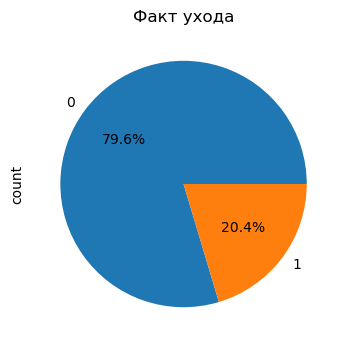

In [19]:
churn['Exited'].value_counts().plot.pie(figsize=(4, 4),
                                       autopct='%1.1f%%', title=ru_name['Exited']);

Заметен дисбаланс примерно 1 к 4

Балансирую обучающую выборку методом Upsampling:

In [20]:
features_train_u, target_train_u = upsample(features_train, target_train)

Результат после балансировки классов целевой переменной:

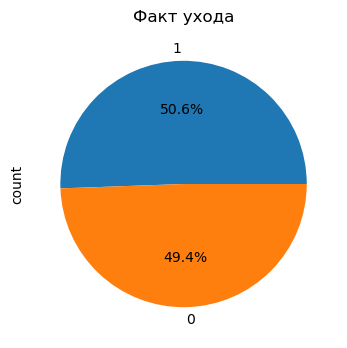

In [21]:
target_train_u.value_counts().plot.pie(figsize=(4, 4),
                                       autopct='%1.1f%%', title=ru_name['Exited']);

### Обучение моделей без учета дисбаланса

Чтобы расчитать метрику ROC-AUC и построить ROC кривую, понадобится этот код:

In [22]:
# функция подсчета AUC и отрисовки кривой
def roc_auc(model, test=False, plot=False, scores=True):
    p_pred_train = model.predict_proba(features_train)[:, 1]
    p_pred_val = model.predict_proba(features_val)[:, 1]
    p_pred_test = model.predict_proba(features_test)[:, 1]
    
    roc_train = roc_auc_score(target_train, p_pred_train)
    roc_val = roc_auc_score(target_val, p_pred_val)
    roc_test = roc_auc_score(target_test, p_pred_test)
    
    if plot:
        plt.figure(figsize=(8, 7))

        plt.plot(*roc_curve(target_train, p_pred_train)[:2], label=f'(train) AUC: {roc_train:.4f}')
        plt.plot(*roc_curve(target_val, p_pred_val)[:2], label=f'(val) AUC: {roc_val:.4f}')

        if test:     # если нужно также нарисовать кривую ROC по тестовой выборке
            plt.plot(*roc_curve(target_test, p_pred_test)[:2], label=f'(test) AUC: {roc_test:.4f}')

        plt.ylabel('True Positive Rate'); plt.xlabel('False Positive Rate')
        plt.title(f'ROC-AUC for {type(model).__name__}')
        plt.plot([0, 1]); plt.ylim([-0.01, 1.01]); plt.xlim([-0.01, 1.01]); plt.legend(); plt.show()
    
    if scores:
        if test:
            return roc_train, roc_val, roc_test
        return roc_train, roc_val
    

Обучение логистической регрессии без учета дисбаланса:

In [23]:
lrgr = LogisticRegression(random_state=42, C=100, penalty='l1', solver='liblinear')
lrgr.fit(features_train, target_train)
pred_val = lrgr.predict(features_val)
_, lrgr_roc_val = roc_auc(lrgr)
lrgr_f1_val = f1_score(target_val, pred_val)

print(f'(val) ROC-AUC: {lrgr_roc_val}')
print(f'(val) f1-score: {lrgr_f1_val}')

(val) ROC-AUC: 0.7908322248497388
(val) f1-score: 0.32792792792792796


Обучение случайного леса без учета дисбаланса:

In [24]:
rf = RandomForestClassifier(random_state=42)
rf.fit(features_train, target_train)
pred_val = rf.predict(features_val)
_, rf_roc_val = roc_auc(rf)
rf_f1_val = f1_score(target_val, pred_val)

print(f'(val) ROC-AUC: {rf_roc_val}')
print(f'(val) f1-score: {rf_f1_val}')

(val) ROC-AUC: 0.8663007131244458
(val) f1-score: 0.5973254086181279


### Повышение качества модели коррекцией дисбаланса классов


Применяю встроенный метод устранения дисбаланса класса:

In [25]:
lrgr_b = LogisticRegression(random_state=42, C=100, penalty='l1', solver='liblinear', class_weight='balanced')
lrgr_b.fit(features_train, target_train)
pred_val = lrgr_b.predict(features_val)
_, lrgr_roc_val_b = roc_auc(lrgr_b)
lrgr_f1_val_b = f1_score(target_val, pred_val)

print(f'(val) ROC-AUC: {lrgr_roc_val_b}')
print(f'(val) f1-score: {lrgr_f1_val_b}')

(val) ROC-AUC: 0.7938205118730909
(val) f1-score: 0.5192143467122119


In [26]:
rf_b = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_b.fit(features_train, target_train)
pred_val = rf_b.predict(features_val)
_, rf_roc_val_b = roc_auc(rf_b)
rf_f1_val_b = f1_score(target_val, pred_val)

print(f'(val) ROC-AUC: {rf_roc_val_b}')
print(f'(val) f1-score: {rf_f1_val_b}')

(val) ROC-AUC: 0.865911204305843
(val) f1-score: 0.5598755832037325


Применяю балансировку методом Upsampling:

In [27]:
lrgr_u = LogisticRegression(random_state=42, C=100, penalty='l1', solver='liblinear')
lrgr_u.fit(features_train_u, target_train_u)
pred_val = lrgr_u.predict(features_val)
_, lrgr_roc_val_u = roc_auc(lrgr_u)
lrgr_f1_val_u = f1_score(target_val, pred_val)

print(f'(val) ROC-AUC: {lrgr_roc_val_u}')
print(f'(val) f1-score: {lrgr_f1_val_u}')

(val) ROC-AUC: 0.7938328283574736
(val) f1-score: 0.5206402695871947


In [28]:
rf_u = RandomForestClassifier(random_state=42)
rf_u.fit(features_train_u, target_train_u)
pred_val = rf_u.predict(features_val)
_, rf_roc_val_u = roc_auc(rf_u)
rf_f1_val_u = f1_score(target_val, pred_val)

print(f'(val) ROC-AUC: {rf_roc_val_u}')
print(f'(val) f1-score: {rf_f1_val_u}')

(val) ROC-AUC: 0.8621954749236378
(val) f1-score: 0.6200527704485488


Модели показали следующие результаты на валидационной выборке: 

In [29]:
pd.DataFrame({'Модель':['Логистическая регрессия', 'Случайный лес'],
             'f1 imbalanced':[round(i, 3) for i in [lrgr_f1_val, rf_f1_val]],
             'f1 balanced (built-in)': [round(i, 3) for i in [lrgr_f1_val_b, rf_f1_val_b]],
             'f1 balanced (upsampling)': [round(i, 3) for i in [lrgr_f1_val_u, rf_f1_val_u]],
             'AUC imbalanced': [round(i, 3) for i in [lrgr_roc_val, rf_roc_val]],
             'AUC balanced (built-in)': [round(i, 3) for i in [lrgr_roc_val_b, rf_roc_val_b]],
             'AUC balanced (upsampling)': [round(i, 3) for i in [lrgr_roc_val_u, rf_roc_val_u]]}
            ).set_index('Модель')

,f1 imbalanced,f1 balanced (built-in),f1 balanced (upsampling),AUC imbalanced,AUC balanced (built-in),AUC balanced (upsampling)
Модель,,,,,,
Логистическая регрессия,0.328,0.519,0.521,0.791,0.794,0.794
Случайный лес,0.597,0.560,0.620,0.866,0.866,0.862


### Вывод, исследование баланса классов
Классы целевой переменной были несбалансированы в соотношении примерно 1 к 4. Методом Upsampling тестовая выборка была приведена к балансу классов, после чего модели логистической регрессии и случайного леса были обучены на несбалансированной выборке, а также на сбалансированной методами Upsampling и встроенными методами моделей (built-in в таблице) 
 
- Видно, что для сбалансированного целевого признака показатель f1 меры растет, также видно, что разные методы балансировки по-разному влияют на результат. Для логистической регрессии не имеет значения, какой метод использовать, а для решающих деревьев (случайного леса) лучше использовать upsampling.
- Логистическая регрессия более чувствительна к дисбалансу, чем случайный лес.
- Исследование также показало, что по сравнению с f1 метрика ROC-AUC практически нечувствительна к изменению баланса классов

## Обучение моделей и выявление модели с наибольшим значением f1

Объявление необходимых функций:

In [30]:
# функция обучения модели на случайно отобранных параметрах и вывода значений f1 и roc-auc метрик 
def finetune(model_name, iterations, parameters, upsampling=False, **kwargs):
    param_list = list(ParameterSampler(parameters, n_iter=iterations, random_state=42))

    best_f1 = 0

    for i in tqdm(range(len(param_list)), colour="green", file=sys.stdout):
        try:
            model = model_name(**param_list[i], random_state=42, n_jobs=-1, **kwargs)
            if upsampling:
                model.fit(features_train_u, target_train_u)
            else:
                model.fit(features_train, target_train)
            pred_val = model.predict(features_val)
            f1 = f1_score(target_val, pred_val)
            if f1 > best_f1:
                best_params = param_list[i]
                best_f1 = f1
                best_model = model
                _, roc_val = roc_auc(best_model)
        except (ValueError):
            pass
    return [best_model, best_params, best_f1, roc_val]

### Логистическая регрессия, поиск оптимальной модели подбором гиперпараметов:

#### Несбалансированная целевая переменная

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.81it/s]


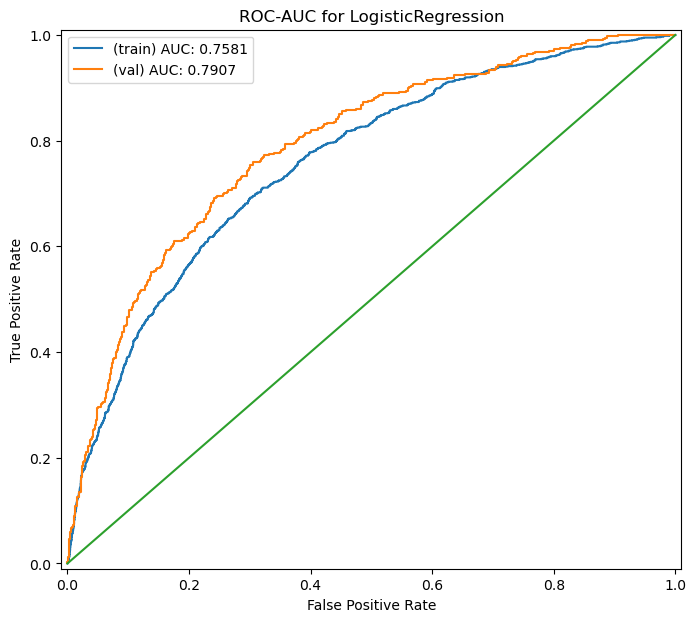

best parameters: {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.8132160804020101}
(val) ROC-AUC: 0.7906536358261896
(val) f1-score: 0.3285198555956679


In [47]:
warnings.filterwarnings("ignore", category=UserWarning)

iters = 100

parameters = {
    'C' : np.linspace(0.01, 10, 200),
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'] 
}

lrgr2, lrgr2_params, lrgr2_f1_val, lrgr2_roc_val = finetune(LogisticRegression, iters, parameters)

roc_auc(lrgr2, plot=True, scores=False)
print(f'best parameters: {lrgr2_params}')
print(f'(val) ROC-AUC: {lrgr2_roc_val}')
print(f'(val) f1-score: {lrgr2_f1_val}')

#### Сбалансированная целевая переменная

Upsampling:

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.08it/s]


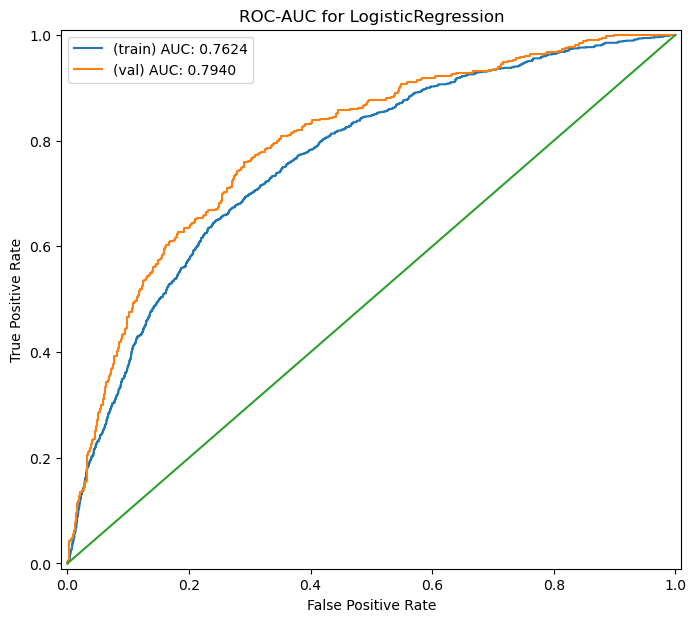

best parameters: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 0.06020100502512563}
(val) ROC-AUC: 0.7940268129865011
(val) f1-score: 0.5227655986509274


In [32]:
warnings.filterwarnings("ignore", category=UserWarning)

lrgr2_u, lrgr2_params_u, lrgr2_f1_val_u, lrgr2_roc_val_u = finetune(LogisticRegression, iters,
                                                                    parameters, upsampling=True)
roc_auc(lrgr2_u, plot=True, scores=False)
print(f'best parameters: {lrgr2_params_u}')
print(f'(val) ROC-AUC: {lrgr2_roc_val_u}')
print(f'(val) f1-score: {lrgr2_f1_val_u}')

Встроенный метод:

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 38.26it/s]


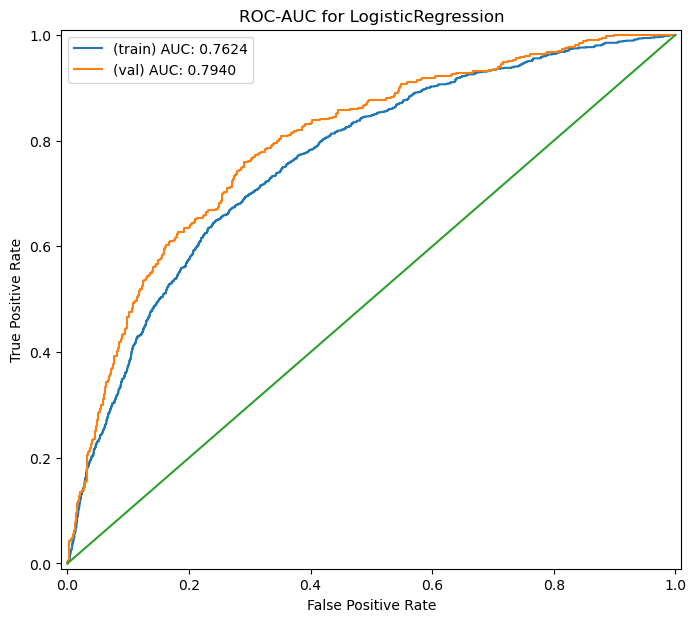

best parameters: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 0.3614070351758794}
(val) ROC-AUC: 0.7938666986895261
(val) f1-score: 0.5221843003412969


In [33]:
warnings.filterwarnings("ignore", category=UserWarning)

lrgr2_b, lrgr2_params_b, lrgr2_f1_val_b, lrgr2_roc_val_b = finetune(LogisticRegression, iters,
                                                                    parameters, class_weight='balanced')
roc_auc(lrgr2_u, plot=True, scores=False)
print(f'best parameters: {lrgr2_params_b}')
print(f'(val) ROC-AUC: {lrgr2_roc_val_b}')
print(f'(val) f1-score: {lrgr2_f1_val_b}')

### Случайный лес, поиск оптимальной модели подбором гиперпараметов:

#### Несбалансированная целевая переменная

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.82it/s]


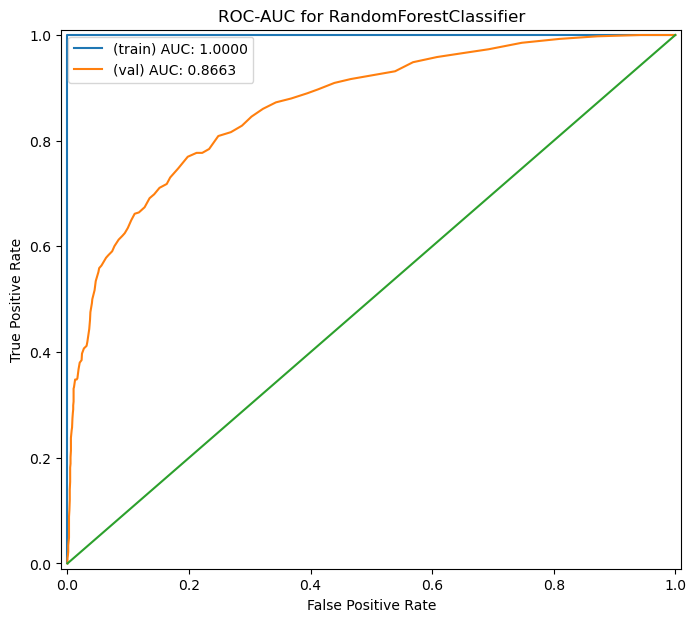

best parameters: {'n_estimators': 88, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 25}
(val) ROC-AUC: 0.8669465587742635
(val) f1-score: 0.6195488721804511


In [34]:
iters = 100

parameters = {
    'n_estimators' : range(10, 100, 2),
    'max_depth': range(1, 31),
    'min_samples_leaf': range(1, 10),
    'min_samples_split': range(2, 10, 2)
}

rf2, rf2_params, rf2_f1_val, rf2_roc_val = finetune(RandomForestClassifier, iters, parameters)

roc_auc(rf, plot=True, scores=False)
print(f'best parameters: {rf2_params}')
print(f'(val) ROC-AUC: {rf2_roc_val}')
print(f'(val) f1-score: {rf2_f1_val}')

#### Сбалансированная целевая переменная

Upsampling:

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:31<00:00,  3.15it/s]


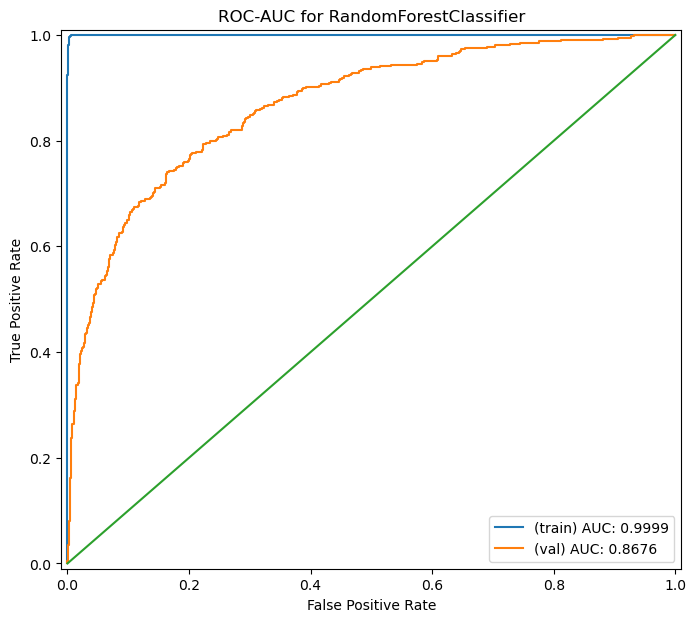

best parameters: {'n_estimators': 98, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_depth': 26}
(val) ROC-AUC: 0.8676378214602423
(val) f1-score: 0.6406619385342789


In [35]:
rf2_u, rf2_params_u, rf2_f1_val_u, rf2_roc_val_u = finetune(RandomForestClassifier, iters, parameters, upsampling=True)

roc_auc(rf2_u, plot=True, scores=False)
print(f'best parameters: {rf2_params_u}')
print(f'(val) ROC-AUC: {rf2_roc_val_u}')
print(f'(val) f1-score: {rf2_f1_val_u}')

Встроенные метод:

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.98it/s]


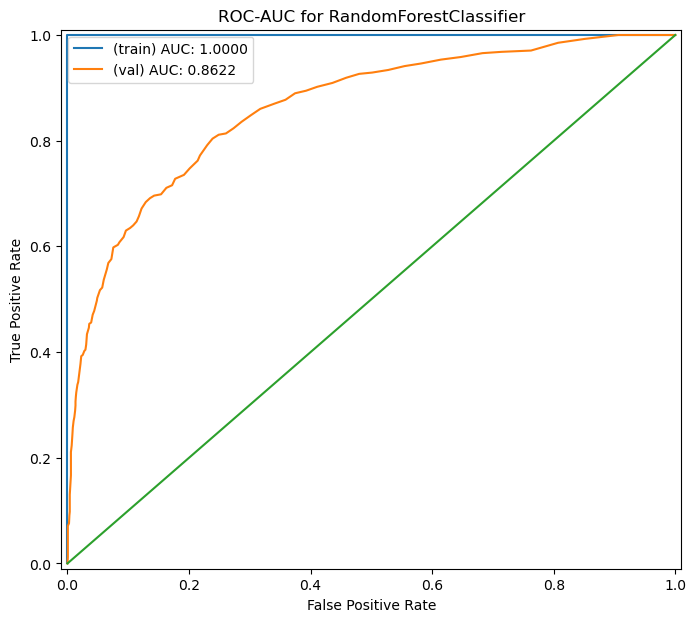

best parameters: {'n_estimators': 66, 'min_samples_split': 4, 'min_samples_leaf': 7, 'max_depth': 18}
(val) ROC-AUC: 0.8689248940782343
(val) f1-score: 0.6471251409244645


In [36]:
rf2_b, rf2_params_b, rf2_f1_val_b, rf2_roc_val_b = finetune(RandomForestClassifier, iters,
                                                        parameters, class_weight='balanced')

roc_auc(rf_u, plot=True, scores=False)
print(f'best parameters: {rf2_params_b}')
print(f'(val) ROC-AUC: {rf2_roc_val_b}')
print(f'(val) f1-score: {rf2_f1_val_b}')

### Градиентный бустинг, поиск оптимальной модели подбором гиперпараметов:

#### Несбалансированная целевая переменная

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:33<00:00,  1.07it/s]


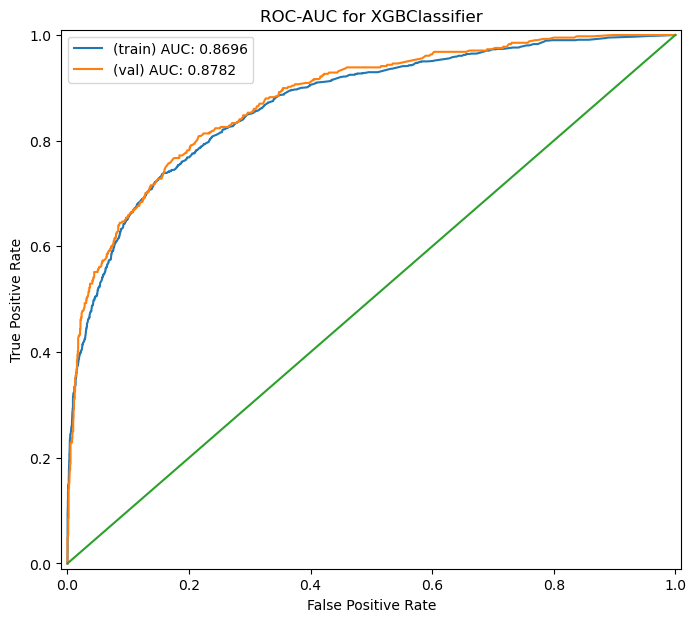

best parameters: {'subsample': 0.56, 'max_depth': 20, 'gamma': 16.4, 'eta': 0.42894736842105263}
(val) ROC-AUC: 0.8782092139619668
(val) f1score: 0.6304985337243401


In [37]:
iters = 100

parameters = {
    'eta' : np.linspace(0.01, 2, 20),
    'max_depth': range(1, 31), 
    'gamma': np.linspace(2, 20, 11),
    'subsample': np.linspace(0.01, 1, 10),
}

gb, gb_params, gb_f1_val, gb_roc_val = finetune(XGBClassifier, iters, parameters)

roc_auc(gb, plot=True, scores=False)
print(f'best parameters: {gb_params}')
print(f'(val) ROC-AUC: {gb_roc_val}')
print(f'(val) f1score: {gb_f1_val}')

#### Сбалансированная целевая переменная

Upsampling:

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:28<00:00,  1.48s/it]


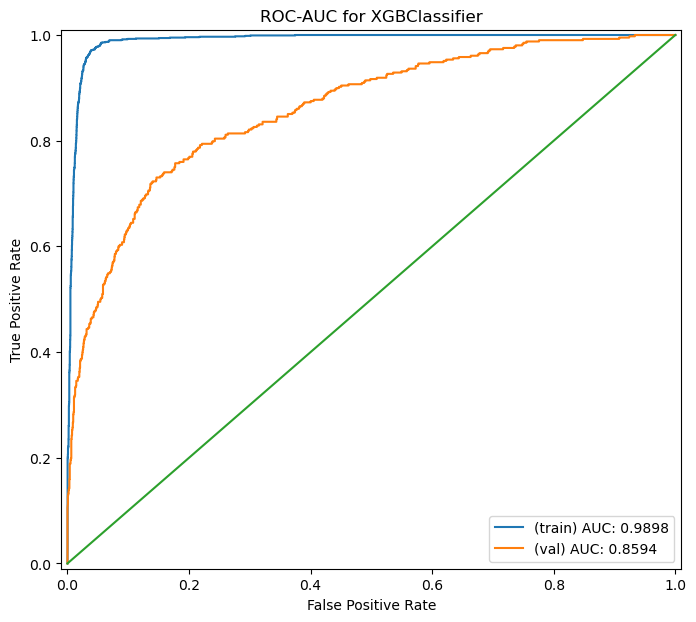

best parameters: {'subsample': 0.67, 'max_depth': 21, 'gamma': 2.0, 'eta': 0.01}
(val) ROC-AUC: 0.859375769780274
(val) f1-score: 0.6363636363636364


In [38]:
gb_u, gb_params_u, gb_f1_val_u, gb_roc_val_u = finetune(XGBClassifier, iters, parameters, upsampling=True)

roc_auc(gb_u, plot=True, scores=False)
print(f'best parameters: {gb_params_u}')
print(f'(val) ROC-AUC: {gb_roc_val_u}')
print(f'(val) f1-score: {gb_f1_val_u}')

Встроенный метод:

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:58<00:00,  1.18s/it]


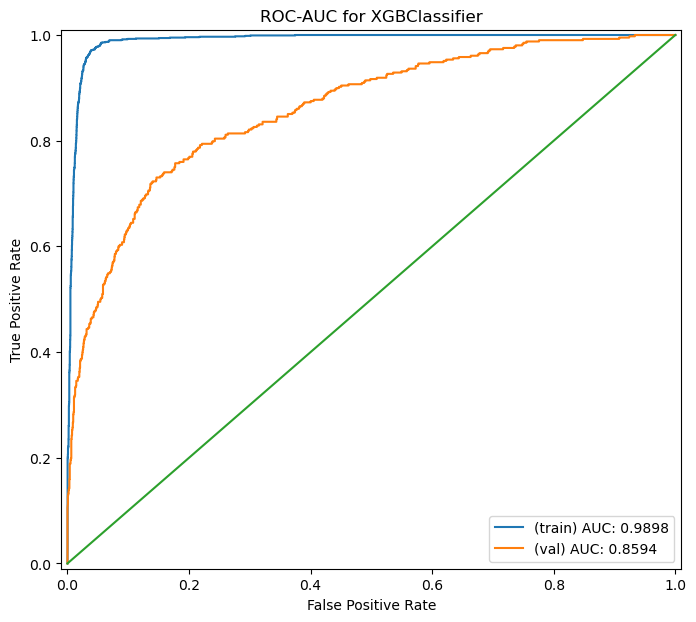

best parameters: {'subsample': 0.67, 'max_depth': 21, 'gamma': 2.0, 'eta': 0.01}
(val) ROC-AUC: 0.859375769780274
(val) f1-score: 0.6363636363636364


In [39]:
gb_b, gb_params_b, gb_f1_val_b, gb_roc_val_b = finetune(XGBClassifier, iters, parameters, scale_pos_weight=4)

roc_auc(gb_u, plot=True, scores=False)
print(f'best parameters: {gb_params_u}')
print(f'(val) ROC-AUC: {gb_roc_val_u}')
print(f'(val) f1-score: {gb_f1_val_u}')

Итоговая таблица с результатами:

In [43]:
final_table = pd.DataFrame({'Модель':['Логистическая регрессия', 'Случайный лес', 'Градиентный бустинг'],
             'f1 imbalanced':[round(i, 3) for i in [lrgr2_f1_val, rf2_f1_val, gb_f1_val]],
             'f1 balanced (built-in)': [round(i, 3) for i in [lrgr2_f1_val_b, rf2_f1_val_b, gb_f1_val_b]],
             'f1 balanced (upsampling)': [round(i, 3) for i in [lrgr2_f1_val_u, rf2_f1_val_u, gb_f1_val_u]],
             'AUC imbalanced': [round(i, 3) for i in [lrgr2_roc_val, rf2_roc_val, gb_roc_val]],
             'AUC balanced (built-in)': [round(i, 3) for i in [lrgr2_roc_val_b, rf2_roc_val_b, gb_roc_val_b]],
             'AUC balanced (upsampling)': [round(i, 3) for i in [lrgr2_roc_val_u, rf2_roc_val_u, gb_roc_val_u]]}
            ).set_index('Модель')
final_table

,f1 imbalanced,f1 balanced (built-in),f1 balanced (upsampling),AUC imbalanced,AUC balanced (built-in),AUC balanced (upsampling)
Модель,,,,,,
Логистическая регрессия,0.329,0.522,0.523,0.791,0.794,0.794
Случайный лес,0.620,0.647,0.641,0.867,0.869,0.868
Градиентный бустинг,0.630,0.634,0.636,0.878,0.868,0.859


### Вывод, обучение моделей и выбор наилучшей

Было проведено тестирование моделей логистической регрессии, случайного леса и градиентного бустинга. В результате обучения моделей с различными гиперпараметрами на валидационной выборке были получены следующие результаты:

- Лучше всего по f1 мере себя показали модели случайного леса (обученные сбалансированных по классам данных: встроенным методом (f1 = 0,647) и методом upsampling (f1 = 0,641)) Затем идут модели градиентного бустинга

- Использование сбалансированных классов для всех моделей приводило к увеличению показателя f1 меры, в то время как показатели метрики ROC-AUC были практически нечувствительны к изменению банаса классов.

- Показатель f1 меры реагировал на балансировку классов сильнее, чем показатель ROC-AUC.

- Моделью с лучшим показателем f1 меры (0,647) является модель случайного леса, обученная со встроенным методом балансировки классов (модель rf_b с параметрами `n_estimators=66, min_samples_split=4, min_samples_leaf=7, max_depth=18`)


## Проведение финального тестирования

### Проверка f1-меры на тестовой выборке

Проверка выбранной модели случайного леса (rf2_b) на тестовых данных:

In [41]:
pred_test = rf2_b.predict(features_test)
print(f'(test) f1-score: {f1_score(target_test, pred_test)}')

(test) f1-score: 0.6228373702422146


Целевой уровень в 0,59 по f1 мере достигнут.

### Измерение AUC-ROC метрики и сравнение её значения с f1-мерой


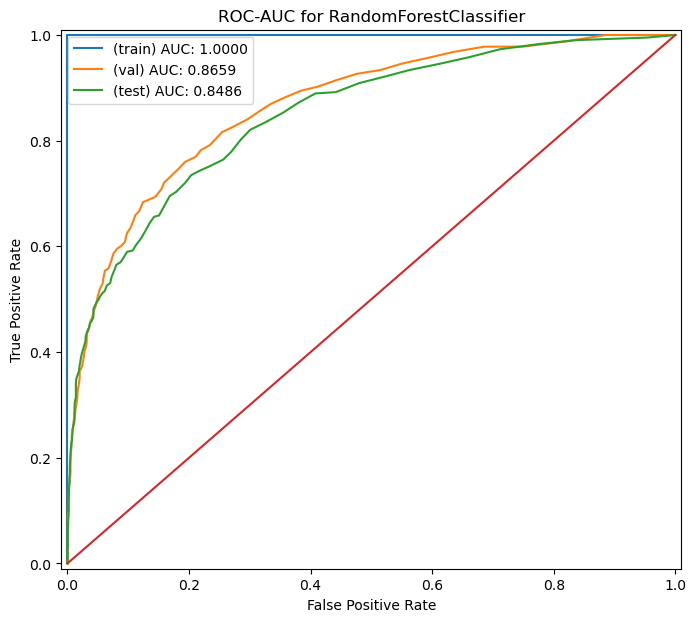

(train) ROC-AUC: 1.0
(val) ROC-AUC: 0.865911204305843
(test) ROC-AUC: 0.8485550265211281

(test) f1 score: 0.6228373702422146


In [42]:
roc_train, roc_val, roc_test = roc_auc(rf_b, test=True, plot=True)

print(f'(train) ROC-AUC: {roc_train}')
print(f'(val) ROC-AUC: {roc_val}')
print(f'(test) ROC-AUC: {roc_test}')
print()

print(f'(test) f1 score: {f1_score(target_test, pred_test)}')

Точность предсказания модели по тестовой выборке доведена до 0,623 для метрики f1 и 0,849 для метрики площади под ROC кривой.
В ходе исследования была выявлена более высокая чувствительность метрики f1 к дисбалансу классов целевой переменной, в то время как метрика ROC-AUC к дисбалансу практически нечувствительна.

## Общий вывод
В ходе исследования данных и построения моделей прогнозирования были получены следующие результаты:

- Классы целевой переменной были несбалансированы в соотношении примерно 1 к 4. Методом Upsampling сформирована альтернативная тестовая выборка, приведенная к балансу классов.

- Для исследования баланса классов были выбраны модели логистической регрессии и случайного леса. Модели показали следующие результаты на валидационной выборке: 


In [46]:
final_table.iloc[:2, :]

,f1 imbalanced,f1 balanced (built-in),f1 balanced (upsampling),AUC imbalanced,AUC balanced (built-in),AUC balanced (upsampling)
Модель,,,,,,
Логистическая регрессия,0.329,0.522,0.523,0.791,0.794,0.794
Случайный лес,0.620,0.647,0.641,0.867,0.869,0.868


- Было выяснено, что для сбалансированного целевого признака показатель f1 меры для этих моделей растет, также обнаружено, что разные методы балансировки по-разному влияют на результат. Для логистической регрессии без разницы, какой использовать встроенный метод, а для решающих деревьев лучше использовать Upsampling.

- В результатае дальнейшего исследования было проведено тестирование моделей логистической регрессии, случайного леса и градиентного бустинга. В результате обучения моделей с различными гиперпараметрами на валидационной выборке было выяснено, что показатель f1 меры реагировал на балансировку классов сильнее, чем показатель ROC-AUC.

- Моделью с лучшим показателем f1 меры (0,647) является модель случайного леса, обученная со встроенным методом балансировки классов (модель rf_b с параметрами `n_estimators=66, min_samples_split=4, min_samples_leaf=7, max_depth=18`)

- Точность предсказания модели по тестовой выборке доведена до 0,605 для метрики f1 и 0,86 для метрики площади под ROC. В ходе исследования была выявлена более высокая чувствительность метрики f1 к дисбалансу классов целевой переменной.

Цели работы достигнуты: построена ML-модель, способная предсказывать отток клиентов с метрикой качества f1 больше или равной 0,59.